In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import WranglerFunctions as wf

In [2]:
RIO_geo = pd.read_csv('../Datasets/Geography_dataset/RIO_geo.csv', index_col = False)
EVR_geo = pd.read_csv('../Datasets/Geography_dataset/EVR_geo.csv', index_col = False)
ANTO_geo = pd.read_csv('../Datasets/Geography_dataset/ANTO_geo.csv', index_col = False)
AAL_geo = pd.read_csv('../Datasets/Geography_dataset/AAL_geo.csv', index_col = False)
GLEN_geo = pd.read_csv('../Datasets/Geography_dataset/GLEN_geo.csv', index_col = False, encoding = 'unicode_escape')
BHP_geo = pd.read_csv('../Datasets/Geography_dataset/BHP_geo.csv', index_col = False)

In [3]:
BHP_geo.iloc[:, 0].values

array(['BHP Group Ltd (BHP AU) - By Geography', nan,
       'In Millions of USD except Per Share', '12 Months Ending',
       'Revenue', '  China', '  Japan', '  Rest Of Asia', '  South Korea',
       '  Australia', '  North America', '  India', '  Europe',
       '  South America', '  Rest Of World', '  Unallocated',
       '  Discontinued', '  Southern Africa', '  United Kingdom',
       'EBITDA', '  Global', 'Income Taxes', '  Rest Of World',
       '  United Kingdom', '  Australia', 'Assets', '  Unallocated',
       '  Discontinued', '  Unallocated', '  Rest Of World',
       '  Southern Africa', '  South America', '  Australia', '  Europe',
       '  North America', '  Global', 'Long-Term Assets', '  Australia',
       '  South America', '  North America', '  Unallocated',
       '  Rest Of World', '  Rest Of World', '  Southern Africa',
       '  United Kingdom', 'Liabilities', '  Global',
       'Depreciation and Amortization', '  Global',
       'Capital Expenditures', '  Disco

In [4]:
# TESTING IF DATASET IS COMPLETE

def test_rev_dataset(df):
    for row in df.iterrows():
        print(sum(row[1].values) - row[1].values[0])
        # ADD SMALL MARGIN OF ERROR - SOME DATA IS NOT COMPLETE IN BLOOMBERG - ONLY EVR HAS SOME SMALL ERROR SO FAR
        assert(sum(row[1].values) < row[1].values[0]*2 + 100)
        assert(sum(row[1].values) > row[1].values[0]*2 - 100)
        
    print("Dataset contains all values for revenue by country")
    
def Geo_Wrangler(df, start_str, end_str):
    #Setting columns as the dates
    df.columns = df.loc[3].values
    #Getting rid of spaces in front of string
    df['12 Months Ending'] = df['12 Months Ending'].str.strip()
    #Removing nan columns
    df = df.loc[:, df.columns.notna()]
    
    # Removing unneccessary rows
    df = df.drop([0, 1, 2, 3, len(df) - 1], axis = 0)
    df = df.reset_index(drop = True)
    
    # Get revenue index
    rev_idx = df['12 Months Ending'][df['12 Months Ending'] == start_str].index[0]
    end_idx = df['12 Months Ending'][df['12 Months Ending'] == end_str].index[0]
    
    # Getting rid of ? and replacing as nan
    df = df.replace('?', np.nan)
    
    # Some float values have commas separating thousands - creates problems when converting to float
    df = df.replace(',','', regex=True)
    
    # Putting dates as rows now
    df = df.T
    
    # Columns as countries
    df.columns = df.loc['12 Months Ending']
    
    # Only selecting relevant columns
    df = df.iloc[:, rev_idx : end_idx]
    
    df = df.drop(['12 Months Ending'], axis = 0)
    
    # Converting values to float
    for column in df.columns:
        df[column] = df[column].astype(float)    
                
    # Missing data as 0.0 - not 100% necessary
    df = df.replace(np.nan, 0.0)
    
    # Date as datetime format
    df = df.reset_index()
    df = df.rename(columns = {"index" : "Date"})
    
    print(wf.format_date(df, 'Date', '%m/%d/%Y'))
    df.index = df['Date']
    df = df.drop('Date', axis = 1)
    
    # Only using data from 2010    
    df = df[df.index > '2010-01-01']
    
    # Following if statements are to remove double counting - in Bloomberg we had North America e.g. and then USA and Canada as children
    # When converted to csv both North America is counted and USA and Canada, where as we only want a single instance
    # Also converting Others to correct continent
    if ('North America' in df.columns):
        if 'United States' in df.columns:
            if 'Canada' in df.columns:
                df = df.drop(['North America'], axis = 1)
                
    if ('Americas' in df.columns):
        if 'USA' in df.columns:
            if 'Mexico' in df.columns:
                df = df.drop(['Americas'], axis = 1)
                index_no = df.columns.get_loc('Mexico')
                column_names = df.columns.values
                column_names[index_no + 1] = "Other countries in Americas"
                df.columns = column_names
    
    if ('Europe' in df.columns):
        if 'Germany' in df.columns:
            df = df.drop(['Europe'], axis = 1)
            if 'Turkey' in df.columns:
                index_no = df.columns.get_loc('Turkey')
                column_names = df.columns.values
                column_names[index_no + 1] = "Other countries in Europe"
                df.columns = column_names
            
    if ('Asia' in df.columns):
        if 'Japan' in df.columns:
            df = df.drop(['Asia'], axis = 1)
            if 'Mongolia' in df.columns:
                index_no = df.columns.get_loc('Mongolia')
                column_names = df.columns.values
                column_names[index_no + 1] = "Other countries in Asia"
                df.columns = column_names
    
    if ('Africa & The Rest Of The World' in df.columns):
        if 'Africa' in df.columns:
            df = df.drop(['Africa & The Rest Of The World'], axis = 1)
            df = df.drop(['Africa'], axis = 1)
            
            if 'Egypt' in df.columns:
                index_no = df.columns.get_loc('Egypt')
                column_names = df.columns.values
                column_names[index_no + 1] = "Other countries in Africa"
                df.columns = column_names
    
    if ('CIS' in df.columns):
        if 'CIS (Excluding Russia)' in df.columns:
            if 'Canada' in df.columns:
                df = df.drop(['CIS'], axis = 1)
                df = df.drop(['CIS (Excluding Russia)'], axis = 1)
                
                if 'Uzbekistan' in df.columns:
                    index_no = df.columns.get_loc('Uzbekistan')
                    column_names = df.columns.values
                    column_names[index_no + 1] = "Other countries in CIS"
                    df.columns = column_names
                
                
    if ('Latin America' in df.columns):
        if 'Chile' in df.columns:
            df = df.drop(['Latin America'], axis = 1)
            
    # Removing columns with no meaningful data
    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 1:
            if unique_values[0] == 0.0:
                df = df.drop([column], axis = 1)
    
    return df

In [5]:
RIO_geo = Geo_Wrangler(RIO_geo, 'Revenue', 'EBITDA Margin')
test_rev_dataset(RIO_geo)
RIO_geo

0
55171.0
60537.0
50967.0
51171.0
47664.0
34829.0
33781.0
40030.0
40522.0
43165.0
44611.0
63495.0
Dataset contains all values for revenue by country


12 Months Ending,Revenue,China,United States,Canada,Other Asia,Japan,Europe,Other Countries,Australia,United Kingdom,Assets Held for Sale,Peru,Chile,Argentina,Australia and New Zealand
Date,,,,,,,,,,,,,,,
2010-12-31,55171.0,16581.0,8975.0,1925.0,8603.0,9410.0,8340.0,2882.0,0.0,1334.0,0.0,0.0,0.0,-4043.0,1164.0
2011-12-31,60537.0,20155.0,9019.0,1926.0,10410.0,10892.0,7549.0,3102.0,0.0,922.0,0.0,0.0,0.0,-5085.0,1647.0
2012-12-31,50967.0,17948.0,7085.0,1823.0,8464.0,8787.0,6380.0,3012.0,1420.0,678.0,0.0,0.0,-4630.0,0.0,0.0
2013-12-31,51171.0,19331.0,7142.0,1276.0,8313.0,8770.0,5552.0,2460.0,1114.0,617.0,0.0,-3404.0,0.0,0.0,0.0
2014-12-31,47664.0,19101.0,6439.0,1421.0,7913.0,7719.0,4407.0,1446.0,1114.0,481.0,-2377.0,0.0,0.0,0.0,0.0
2015-12-31,34829.0,14558.0,5292.0,1488.0,4695.0,3907.0,2783.0,900.0,867.0,339.0,0.0,0.0,0.0,0.0,0.0
2016-12-31,33781.0,14405.0,4762.0,1099.0,5011.0,3681.0,2621.0,1135.0,715.0,352.0,0.0,0.0,0.0,0.0,0.0
2017-12-31,40030.0,17706.0,5716.0,1111.0,5108.0,4701.0,3015.0,1514.0,710.0,449.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,40522.0,18061.0,6278.0,1340.0,4665.0,3873.0,3706.0,1493.0,720.0,386.0,0.0,0.0,0.0,0.0,0.0


In [6]:
EVR_geo = Geo_Wrangler(EVR_geo, 'Revenue', 'Revenue Growth %')
test_rev_dataset(EVR_geo)
EVR_geo

0
13394.0
16400.0
14726.0
14411.0
13061.0
8690.0
7475.0
9947.0
12963.0
11905.0
9754.0
13486.0
Dataset contains all values for revenue by country


,Revenue,Russia,Kazakhstan,Ukraine,Kyrgyzstan,Belarus,Uzbekistan,Other countries in CIS,USA,Canada,...,Poland,Czech Republic,Austria,Germany,Italy,Kenya,Egypt,Other countries in Africa,Republic Of South Africa,Other Countries
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,13394.0,4692.0,342.0,471.0,0.0,0.0,0.0,0.0,1674.0,1451.0,...,139.0,189.0,188.0,219.0,205.0,0.0,0.0,0.0,407.0,639.0
2011-12-31,16400.0,6632.0,401.0,623.0,0.0,0.0,0.0,163.0,2172.0,1478.0,...,221.0,205.0,224.0,368.0,267.0,0.0,0.0,72.0,472.0,5.0
2012-12-31,14726.0,6191.0,355.0,473.0,0.0,0.0,0.0,168.0,2293.0,1234.0,...,131.0,155.0,160.0,204.0,224.0,0.0,0.0,74.0,323.0,6.0
2013-12-31,14411.0,6136.0,456.0,494.0,0.0,0.0,0.0,225.0,1940.0,1233.0,...,100.0,151.0,173.0,163.0,157.0,0.0,0.0,43.0,361.0,7.0
2014-12-31,13061.0,5279.0,384.0,333.0,0.0,0.0,0.0,209.0,1727.0,1589.0,...,37.0,58.0,139.0,74.0,114.0,0.0,0.0,84.0,363.0,10.0
2015-12-31,8600.0,3104.0,237.0,242.0,8.0,60.0,35.0,185.0,1566.0,779.0,...,0.0,0.0,0.0,0.0,0.0,44.0,43.0,158.0,0.0,6.0
2016-12-31,7411.0,3080.0,184.0,296.0,12.0,45.0,41.0,150.0,826.0,682.0,...,0.0,0.0,0.0,0.0,0.0,78.0,138.0,45.0,0.0,4.0
2017-12-31,9949.0,4255.0,36.0,368.0,36.0,62.0,37.0,55.0,1465.0,546.0,...,0.0,0.0,0.0,0.0,0.0,106.0,100.0,20.0,0.0,5.0
2018-12-31,12931.0,4564.0,237.0,480.0,50.0,72.0,32.0,97.0,2226.0,537.0,...,0.0,0.0,0.0,0.0,0.0,77.0,86.0,16.0,0.0,6.0


In [7]:
AAL_geo = Geo_Wrangler(AAL_geo, 'Revenue', 'Operating Income')
test_rev_dataset(AAL_geo)
AAL_geo

0
27960.0
30580.0
35157.0
0.0
27073.0
23003.0
23142.0
28650.0
30196.0
31825.0
26883.0
43258.0
Dataset contains all values for revenue by country


12 Months Ending,Revenue,China,Other Asia,Other Europe,Japan,United Kingdom,India,North America,Other Africa,South Africa,Brazil,Chile,Other South America,Australia,Associates & Joint Ventures,Unallocated Investments In Associates,Europe,Australia & Asia,South America
Date,,,,,,,,,,,,,,,,,,,
2010-12-31,27960.0,0.0,0.0,0.0,0.0,0.0,0.0,679.0,2329.0,15711.0,0.0,0.0,0.0,0.0,0.0,-4969.0,2577.0,4141.0,7492.0
2011-12-31,30580.0,0.0,0.0,0.0,0.0,0.0,0.0,615.0,2763.0,17855.0,0.0,0.0,0.0,0.0,0.0,-5968.0,2319.0,5058.0,7938.0
2012-12-31,35157.0,0.0,0.0,0.0,0.0,0.0,0.0,559.0,3256.0,14592.0,1274.0,5122.0,0.0,0.0,0.0,-4024.0,2235.0,4616.0,7527.0
2013-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31,27073.0,0.0,0.0,0.0,0.0,0.0,0.0,1218.0,1663.0,2464.0,0.0,0.0,0.0,0.0,-3915.0,0.0,8109.0,15539.0,1995.0
2015-12-31,23003.0,0.0,0.0,0.0,0.0,0.0,0.0,855.0,982.0,1764.0,0.0,0.0,0.0,12821.0,0.0,0.0,5324.0,0.0,1257.0
2016-12-31,23142.0,4784.0,3813.0,3175.0,2131.0,1341.0,2756.0,572.0,1604.0,1630.0,679.0,481.0,12.0,164.0,0.0,0.0,0.0,0.0,0.0
2017-12-31,28650.0,6451.0,5514.0,3489.0,2625.0,1571.0,3636.0,875.0,1709.0,1876.0,422.0,432.0,9.0,41.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,30196.0,6933.0,5813.0,3924.0,2840.0,1889.0,3796.0,714.0,1816.0,1466.0,383.0,540.0,35.0,47.0,0.0,0.0,0.0,0.0,0.0


In [8]:
AAL_geo

12 Months Ending,Revenue,China,Other Asia,Other Europe,Japan,United Kingdom,India,North America,Other Africa,South Africa,Brazil,Chile,Other South America,Australia,Associates & Joint Ventures,Unallocated Investments In Associates,Europe,Australia & Asia,South America
Date,,,,,,,,,,,,,,,,,,,
2010-12-31,27960.0,0.0,0.0,0.0,0.0,0.0,0.0,679.0,2329.0,15711.0,0.0,0.0,0.0,0.0,0.0,-4969.0,2577.0,4141.0,7492.0
2011-12-31,30580.0,0.0,0.0,0.0,0.0,0.0,0.0,615.0,2763.0,17855.0,0.0,0.0,0.0,0.0,0.0,-5968.0,2319.0,5058.0,7938.0
2012-12-31,35157.0,0.0,0.0,0.0,0.0,0.0,0.0,559.0,3256.0,14592.0,1274.0,5122.0,0.0,0.0,0.0,-4024.0,2235.0,4616.0,7527.0
2013-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31,27073.0,0.0,0.0,0.0,0.0,0.0,0.0,1218.0,1663.0,2464.0,0.0,0.0,0.0,0.0,-3915.0,0.0,8109.0,15539.0,1995.0
2015-12-31,23003.0,0.0,0.0,0.0,0.0,0.0,0.0,855.0,982.0,1764.0,0.0,0.0,0.0,12821.0,0.0,0.0,5324.0,0.0,1257.0
2016-12-31,23142.0,4784.0,3813.0,3175.0,2131.0,1341.0,2756.0,572.0,1604.0,1630.0,679.0,481.0,12.0,164.0,0.0,0.0,0.0,0.0,0.0
2017-12-31,28650.0,6451.0,5514.0,3489.0,2625.0,1571.0,3636.0,875.0,1709.0,1876.0,422.0,432.0,9.0,41.0,0.0,0.0,0.0,0.0,0.0
2018-12-31,30196.0,6933.0,5813.0,3924.0,2840.0,1889.0,3796.0,714.0,1816.0,1466.0,383.0,540.0,35.0,47.0,0.0,0.0,0.0,0.0,0.0


In [9]:
ANTO_geo = Geo_Wrangler(ANTO_geo, 'Revenue', 'EBITDA')
test_rev_dataset(ANTO_geo)
ANTO_geo

0
6999.0
6291.7
5279.300000000004
3225.7000000000007
3621.7
4749.4000000000015
4733.0999999999985
4964.499999999998
5129.2999999999965
7470.1
Dataset contains all values for revenue by country


12 Months Ending,Revenue,Japan,China,Singapore,South Korea,Rest of Asia,Hong Kong,Switzerland,Rest of Europe,Germany,Spain,United Kingdom,North America,Chile,Rest of Latin America,United States
Date,,,,,,,,,,,,,,,,
2012-12-31,6999.0,2390.5,1508.9,0.0,0.0,1209.5,0.0,77.3,385.6,24.4,225.7,35.2,258.9,386.7,237.4,258.9
2013-12-31,6291.7,1984.5,1423.9,0.0,0.0,934.7,0.0,143.9,232.4,146.4,208.2,15.8,320.1,375.3,186.4,320.1
2014-12-31,5279.3,1965.4,1253.1,0.0,0.0,826.0,0.0,138.5,137.7,146.1,160.6,8.2,133.7,215.3,161.0,133.7
2015-12-31,3225.7,1147.0,623.8,0.0,0.0,625.8,0.0,175.2,68.9,167.0,54.1,19.1,105.2,165.5,74.1,0.0
2016-12-31,3621.7,1483.5,771.9,0.0,0.0,556.1,0.0,217.7,157.3,38.5,115.6,0.0,49.5,105.2,126.4,0.0
2017-12-31,4749.4,1698.2,484.8,0.0,0.0,728.1,0.0,835.1,114.2,139.4,163.5,46.6,207.4,206.9,125.2,0.0
2018-12-31,4733.1,1413.0,481.2,633.9,322.0,130.3,117.1,587.0,131.7,117.3,152.9,125.3,199.4,248.1,73.9,0.0
2019-12-31,4964.5,1561.5,517.2,692.1,371.2,143.1,171.0,612.4,85.0,102.7,158.0,152.3,88.9,213.8,95.3,0.0
2020-12-31,5129.3,1631.1,531.4,667.5,353.4,132.5,235.7,593.5,92.3,116.4,29.3,123.3,216.5,224.4,182.0,0.0


In [10]:
BHP_geo = Geo_Wrangler(BHP_geo, 'Revenue', 'EBITDA')
test_rev_dataset(BHP_geo)
BHP_geo

0
52798.0
71739.0
72226.0
0.0
56762.0
44636.0
28567.0
35740.0
43129.0
44288.0
42931.0
60817.0
Dataset contains all values for revenue by country


12 Months Ending,Revenue,China,Japan,Rest Of Asia,South Korea,Australia,North America,India,Europe,South America,Rest Of World,Southern Africa,United Kingdom
Date,,,,,,,,,,,,,
2010-06-30,52798.0,13236.0,5336.0,9840.0,0.0,4515.0,5547.0,0.0,8554.0,2013.0,1241.0,1227.0,1289.0
2011-06-30,71739.0,20261.0,9002.0,15805.0,0.0,5487.0,6167.0,0.0,8370.0,2592.0,1464.0,1548.0,1043.0
2012-06-30,72226.0,21617.0,8920.0,15035.0,0.0,5318.0,8099.0,0.0,7419.0,2013.0,1412.0,1437.0,956.0
2013-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-30,56762.0,21873.0,6305.0,3816.0,4104.0,3106.0,9607.0,2009.0,2457.0,1994.0,512.0,0.0,979.0
2015-06-30,44636.0,16337.0,4863.0,4734.0,2688.0,2205.0,7990.0,1680.0,2465.0,1342.0,332.0,0.0,0.0
2016-06-30,28567.0,13177.0,2941.0,2623.0,1919.0,1846.0,2355.0,1478.0,1141.0,899.0,188.0,0.0,0.0
2017-06-30,35740.0,18644.0,3036.0,3152.0,2271.0,2037.0,2233.0,1891.0,1641.0,649.0,186.0,0.0,0.0
2018-06-30,43129.0,22660.0,4628.0,2620.0,2588.0,2304.0,2715.0,2439.0,1886.0,1054.0,235.0,0.0,0.0


In [11]:
GLEN_geo = Geo_Wrangler(GLEN_geo, 'Revenue', 'Revenue Including Intersegment Revenue')
test_rev_dataset(GLEN_geo)
GLEN_geo

0
144978.0
186152.0
214436.0
232694.0
221073.0
147351.0
152948.0
205476.0
219754.0
215111.0
142338.0
203751.0
Dataset contains all values for revenue by country


12 Months Ending,Revenue,Asia,Europe,Americas,Africa,Oceania
Date,,,,,,
2010-12-31,144978.0,42820.0,47724.0,39183.0,13975.0,1276.0
2011-12-31,186152.0,47759.0,70323.0,45836.0,20538.0,1696.0
2012-12-31,214436.0,44274.0,108904.0,42295.0,16910.0,2053.0
2013-12-31,232694.0,67858.0,78782.0,54675.0,25665.0,5714.0
2014-12-31,221073.0,86619.0,70595.0,47274.0,8206.0,8379.0
2015-12-31,147351.0,55879.0,46758.0,29422.0,4824.0,10468.0
2016-12-31,152948.0,61060.0,55021.0,22401.0,3934.0,10532.0
2017-12-31,205476.0,82694.0,72459.0,33930.0,4800.0,11593.0
2018-12-31,219754.0,94643.0,75991.0,36939.0,5240.0,6941.0


## Revenue and countries that companies sell to

In [12]:
def plotCountryRevenue(df_revenue, companyName, num_columns):
    fig, ax = plt.subplots(figsize=(8,6))
        
    ax.plot(df_revenue.index, df_revenue['Revenue'], label='Revenue in ' + companyName, lw=2, marker='o')
    
    for column_idx in range(1, num_columns):
        ax.plot(df_revenue.index, df_revenue[df_revenue.columns[column_idx]], label = "Revenue from " + df_revenue.columns[column_idx], lw = 2, marker = 'x')
        
    ax.set_xlabel('Time')
    ax.set_ylabel('Revenue')
    ax.grid()
    
    colormap = plt.cm.gist_ncar   
    colors = [colormap(i) for i in np.linspace(0, 0.8, len(ax.lines))]
    for i,j in enumerate(ax.lines):
        j.set_color(colors[i])


    ax.legend(bbox_to_anchor=(1, 0.5))

    plt.show()

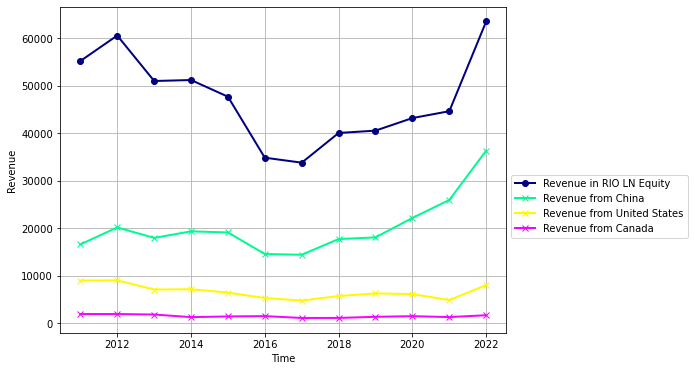

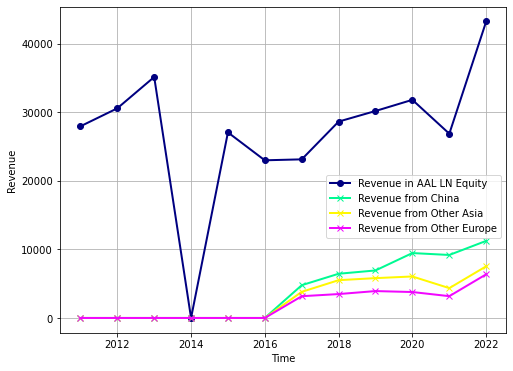

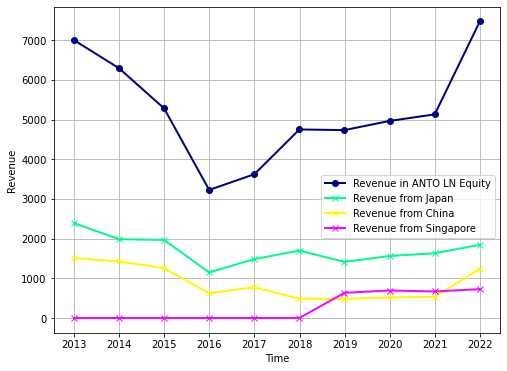

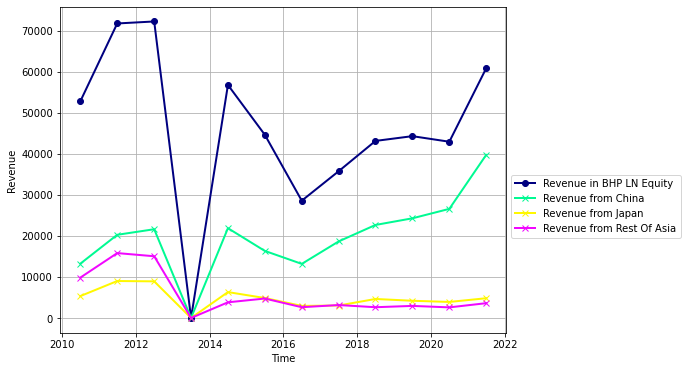

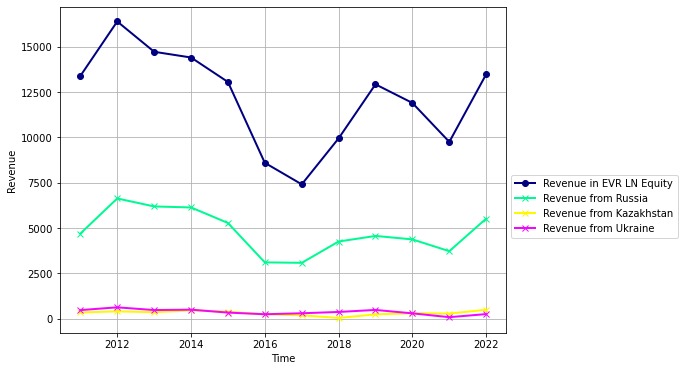

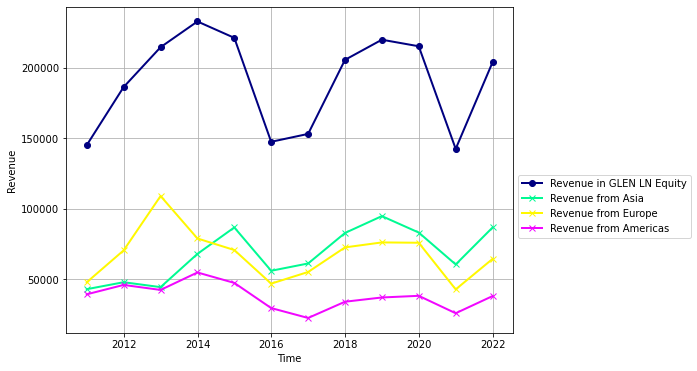

In [13]:
geo_datasets = [RIO_geo, AAL_geo, ANTO_geo, BHP_geo, EVR_geo, GLEN_geo]
geo_company_names = ['RIO LN Equity', 'AAL LN Equity', 'ANTO LN Equity', 'BHP LN Equity', 'EVR LN Equity', 'GLEN LN Equity']

for i in range(len(geo_datasets)):
    plotCountryRevenue(geo_datasets[i], geo_company_names[i], 4)